<a href="https://colab.research.google.com/github/FeryET/DeepLearning_CA7/blob/master/DL_CA7_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading requirements

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
!kaggle datasets download -d adityajn105/flickr8k
!unzip -qo "/content/flickr8k.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 99% 1.02G/1.04G [00:29<00:00, 39.5MB/s]
100% 1.04G/1.04G [00:29<00:00, 37.2MB/s]


In [122]:
import gc
import numpy as np
from PIL import Image
import re
import string
from glob import glob
import pandas as pd
import string 
import itertools
import collections
import textwrap 
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms


import gensim.downloader as api
import random 


# Defining Constants

In [121]:
# Locations
IMAGE_ROOT = "/content/Images"
CAPTION_CSV_LOC = "/content/captions.txt"
SAVE_LOCATION = "/content/drive/MyDrive/Academics/Courses/Deep Learning/CA3/Q1/"

if not os.path.isdir(SAVE_LOCATION):
  os.mkdir(SAVE_LOCATION)

# Tokens
START_TOKEN = "<SOS>"
END_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Captions related
MAX_LENGTH = 256 
LSTM_HIDDEN_SIZE = 256 # LSTM units?
MIN_WORD_FREQ = 10
EMBEDDING_DIM = 100
CAPTIONS_PER_IMAGE = 5

MIN_WORD_LENGTH = 2


MAX_EPOCHS = 100

# Dataset specifice
TEST_SPLIT = 0.1

# Processing Documents

### Preprocessing Captions

In [152]:
def preprocess_text(text):
  prep = text.lower()
  # remove whitespace, numerics and punctuations and replace them with space
  prep = re.sub("(\s+)|(\d+)|([^\w\s]+)", " ", prep)
  prep = prep.split()
  prep = [p for p in prep if len(p) >= MIN_WORD_LENGTH]
  return prep

caption_df = pd.read_csv(CAPTION_CSV_LOC)
caption_df.sort_values(by="image", inplace=True)
caption_df["cleaned"] = caption_df["caption"].apply(preprocess_text)

### Creating Vocabulary

In [153]:
counter = collections.Counter(itertools.chain(*caption_df["cleaned"]))
words = sorted([v for v, n in counter.items() if n > MIN_WORD_FREQ])
words = [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN] + words
vocab = {w: idx for idx, w in enumerate(words)}
id2word = {idx: w for idx, w in enumerate(words)}
print(f"Vocabulary Length: {len(vocab)}")

Vocabulary Length: 1849


### Creating Wordvectors

In [87]:
glove = api.load(f"glove-twitter-{EMBEDDING_DIM}")
matrix_len = len(vocab)
glove_embedding = np.zeros((matrix_len, EMBEDDING_DIM), dtype=np.float64)
words_found = 0

for i, word in enumerate(vocab):
    try: 
        glove_embedding[i] = glove.wv[word]
        words_found += 1
    except KeyError:
        glove_embedding[i] = np.random.normal(scale=1/EMBEDDING_DIM, size=(EMBEDDING_DIM,))
print(words_found)
del glove

[==================================================] 100.0% 387.1/387.1MB downloaded
1839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


### Defining Augmenter Class

In [11]:
class Augmenter:
  def __init__(self, transforms, p=0.5):
    self.p = p
    self.disable = False
    self.transforms = transforms
  
  def __call__(self, x):
    if (not self.disable) and np.random.random() > self.p:
        x = self.transforms(x)
    return x

### Defining Transforms for Captions

In [80]:
# Augmenters
class RandomSubstitute:
  def __init__(self, words, p=0.1, min_length=10):
    self.p = p
    self.words = words
    self.min_length = min_length
  
  def __call__(self, sent):
    if len(sent) > self.min_length:
      return [w if np.random.random() > self.p else np.random.choice(self.words) for w in sent]
    else:
      return sent

class RandomInsertion:
  def __init__(self, words, p=0.5, max_words=3):
    self.p = p
    self.words = words
    self.max_words = 5
  
  def __call__(self, sent):
    if len(sent) > self.max_words * 2:
      choices = np.random.choice(range(len(sent)), size=(self.max_words))
      indices = np.random.random(size=(self.max_words)) > self.p
      choices = choices[indices]
      for i in choices:
          sent.insert(i, np.random.choice(self.words))
    return sent

class RandomDrop:
  def __init__(self, p=0.1, min_length = 10):
    self.p = p
    self.min_length = min_length

  def __call__(self, sent):
    if len(sent) >= self.min_length:
      return [w for w in sent if np.random.random() > self.p]
    else:
      return sent

# Transforms
class VocabTransform:
  def __init__(self, vocab):
    self.vocab = vocab
  
  def __call__(self, tokenized):
    return [self.vocab[t] if t in self.vocab.keys() else self.vocab[UNK_TOKEN] for t in tokenized]

class CaptionConditioner:
  def __init__(self, max_length=MAX_LENGTH):
    self.max_length = max_length
  
  def __call__(self, tokenized):
    return [START_TOKEN] + tokenized[:self.max_length - 2] + [END_TOKEN]

class TextIndicesToTensor:
  def __call__(self, item):
    return torch.tensor(tuple(item), dtype=torch.int64)



caption_augmenter = Augmenter(
    transforms.RandomChoice([
                        # Not a pad, sos or eos token
                        RandomSubstitute(words=words[3:]),
                        RandomInsertion(words=words[3:]),
                        RandomDrop()
    ])
)

caption_transforms = transforms.Compose(
    [
     caption_augmenter,
     CaptionConditioner(),
     VocabTransform(vocab),
     TextIndicesToTensor(),
    ]
)

### Images

In [73]:
# List of augmentations to choose from
augment_choices = transforms.RandomChoice([
                                      transforms.RandomAffine(
                                          degrees=(-5,5),
                                          translate=(0.1,0.1),
                                          scale=(0.9,1.1),
                                          ),
                                      transforms.RandomHorizontalFlip(p=1),
                                      transforms.RandomVerticalFlip(p=1),
                                      transforms.RandomErasing(p=1),
                                      ])

# To either augment or not
image_augmenter = Augmenter(augment_choices)

# This is copied from https://pytorch.org/hub/pytorch_vision_resnet/
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224), # As an augmenting process
    transforms.ToTensor(),
    image_augmenter,
    transforms.Normalize(mean=image_mean, std=image_std),
])

image_mean = np.array(image_mean)
image_std = np.array(image_std)

# Defining the Dataset

In [195]:
class FlickrDataset(Dataset):
  def __init__(self, 
               images_path, 
               caption_df, 
               image_transforms, 
               caption_transforms,
               augmenters,
               captions_per_image=CAPTIONS_PER_IMAGE):
    self.images_path = images_path
    self.images_fnames = sorted(os.listdir(images_path))
    self.df = caption_df
    self.captions_per_image = captions_per_image
    self.no_transform = False
    self.no_augment = False
    self.image_transforms = image_transforms
    self.caption_transforms = caption_transforms
    self.augmenters = augmenters

  def __len__(self):
    return len(self.df)


  def switch_augment_status(self, disable=False):
    self.no_augment = disable
    for aug in self.augmenters:
        aug.disable = disable

  def __getitem__(self, idx):
    fname = self.df.iloc[idx]["image"]
    fpath = os.path.join(self.images_path, fname)
    image = Image.open(fpath)
    caption = self.df.iloc[idx]["cleaned"]
    if not self.no_transform:
      caption = self.caption_transforms(caption)
      image = self.image_transforms(image)
    return image, caption

  
  def generate_train_test_indices(self, split=0.1, seed=42):
    indices = np.arange(len(self) // self.captions_per_image) * self.captions_per_image

    random.seed(seed)
    random.shuffle(indices)
    random.seed()

    indice_split_index = int(len(indices) * (1 - split))
    train_indices, test_indices = indices[:indice_split_index], indices[indice_split_index:]

    train_indices = [range(x,x+self.captions_per_image) for x in train_indices]
    test_indices = [range(x,x+self.captions_per_image) for x in test_indices]

    train_indices = [x for pack in train_indices for x in pack]
    test_indices = [x for pack in test_indices for x in pack]
  

    return train_indices, test_indices

In [88]:

# Influenced by https://github.com/siddsrivastava/Image-captioning/blob/master/model.py

class FlickrEncoderCNN(nn.Module):
  def __init__(self, 
               embedding_dim, 
               freeze):
    super().__init__()
    # Loading resnet
    resnet = torchvision.models.resnet18(pretrained=True)
    fc_in_features = resnet.fc.in_features

    # Defining layers
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.fc = nn.Linear(fc_in_features, embedding_dim)

    # Freezing if needed
    for param in self.resnet.parameters():
        param.requires_grad = False if freeze else True
    for param in self.fc.parameters():
      param.requires_grad = True
    
    self.modules = nn.ModuleList(
        [self.resnet, self.fc]
    )  
  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x


class FlickrDecoderLSTM(nn.Module):
  def __init__(self, 
                vocab_size,
                embedding_dim,
                hidden_size,
                padding_idx,
                bidirectional=False,
                dropout=0):
    
    super().__init__()
    # Creating embeddings
    self.embed = nn.Embedding(num_embeddings=vocab_size,
                              embedding_dim=embedding_dim, 
                              padding_idx=padding_idx,
                              sparse=False,
                              )
    # self.embed = nn.Embedding.from_pretrained(
    #     torch.FloatTensor(glove_embedding))

    self.lstm = nn.LSTM(input_size=embedding_dim,
                        hidden_size=hidden_size,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=bidirectional)
    

    self.fc = nn.Linear(hidden_size,vocab_size)

    self.modules = nn.ModuleList(
        [self.embed, self.lstm, self.fc]
    )

  def forward(self, features, caption_seqs, hidden=None):
      caption_seqs = caption_seqs[:,:-1] 
      embeddings = self.embed(caption_seqs)
      total_input = torch.cat((features.unsqueeze(1), embeddings), 1)
      lstm_out, hidden = self.lstm(total_input, hidden)
      outputs = self.fc(lstm_out)
      return outputs, hidden


class FlickrNet(nn.Module):
  def __init__(self, 
               vocab_size,
               embedding_dim,
               hidden_size,
               padding_idx,
               start_token_index,
               end_token_index,
               unk_token_index,
               bidirectional=False,
               dropout=0,
               freeze=True):
    super().__init__()
    self.vocab_size = vocab_size
    encoder = FlickrEncoderCNN(embedding_dim, freeze)
    decoder = FlickrDecoderLSTM(vocab_size, 
                                    embedding_dim, 
                                    hidden_size, 
                                    padding_idx, 
                                    bidirectional, 
                                    dropout)
    self.encoder = encoder
    self.decoder = decoder
    self.modules = nn.ModuleList([encoder,decoder])
    self.start_token_index = start_token_index
    self.end_token_index = end_token_index
    self.unk_token_index = unk_token_index

  def forward(self, images, caption_seqs):
    features = self.encoder(images)
    outputs, hiddens = self.decoder(features, caption_seqs)
    return outputs
  
  def predict(self, image, max_len = 30):
      output = []
      hidden_size = self.decoder.lstm.hidden_size
      hidden = (torch.zeros(1,1,hidden_size).to(image.device),
                  torch.zeros(1,1,hidden_size).to(image.device))
      inputs = self.encoder(image).unsqueeze(1)
      for i in range(max_len):
        lstm_out, hidden = self.decoder.lstm(inputs,hidden)    
        output_vocab = self.decoder.fc(lstm_out)    
        output_vocab = output_vocab.squeeze(1)  
        output_word = output_vocab.argmax(1)                
        word = output_word.item()
        output.append(word)
        if word == self.end_token_index:
          break
        inputs = self.decoder.embed(output_word.unsqueeze(0))   
      return output

In [175]:
class PadCaptions:
  def __init__(self, vocab):
    self.pad_idx = vocab[PAD_TOKEN]
  
  def __call__(self, batch):
    images, captions = list(zip(*batch))
    captions = torch.nn.utils.rnn.pad_sequence(captions,
                                    batch_first=True,
                                    padding_value=self.pad_idx)
    images = [im.unsqueeze(0) for im in images]
    images = torch.cat(images, dim=0)
    return images, captions

# class RepeatImages:
#   def __init__(self, num_repeat=CAPTIONS_PER_IMAGE):
#     self.num_repeat = num_repeat

#   def __call__(self, batch):
#     result = []
#     for image, captions in batch:
#       for i in range(self.num_repeat):
#         result.append((image, captions[i]))
#     np.random.shuffle(result)
#     return result


batch_transforms = transforms.Compose([
     PadCaptions(vocab),
     ]
)

# Preparing for Training

### Defining training and testing functions

In [213]:
def generate_sentence(model, n = 2):
    print("#########################")  
    nums = np.random.randint(0, len(test_dataset), size=(n,))
    for i in nums:
      image, captions = test_dataset[i]
      image = image.unsqueeze(0).cuda()
      gen = model.predict(image)
      gen = " ".join([id2word[g] for g in gen])
      caption = " ".join([id2word[c] for c in captions.numpy()])
      print(f"### Original: {caption}")
      print(f"### Generated: {gen}")
    print("#########################")
    
def test(model, loss_function, test_loader):
  test_loss = 0
  n_items = 0
  with torch.no_grad():
    model.eval()
    for batch in test_loader:
        images, captions = batch
        images, captions = images.cuda(), captions.cuda()

        outputs = model(images, captions)
        outputs = torch.moveaxis(outputs, -1, 1)
        loss = loss_function(outputs, captions)
      
        test_loss += loss.item() * captions.numel()
        n_items += captions.numel()
        
  test_loss /= n_items
  return test_loss

def train(model, optimizer, loss_function, train_loader, test_loader, model_name, dataset, max_epochs=50):
  scaler = torch.cuda.amp.GradScaler()
  info = []
  for epoch in range(1, max_epochs+1):
    model.train()
    train_loss = 0
    n_items = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch: {epoch}", leave=False)
    dataset.switch_augment_status(disable=False)
    for batch in train_loader:
      optimizer.zero_grad()

      images, captions = batch
      images, captions = images.cuda(), captions.cuda()
      
      with torch.cuda.amp.autocast():
        outputs = model(images, captions)
        outputs = torch.moveaxis(outputs, -1, 1)
        loss = loss_function(outputs, captions)

      # scaling the loss
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      
      # computing the running loss
      train_loss += loss.item() * captions.numel()
      n_items += captions.numel()

      # updating the progress bar
      pbar.set_postfix(batch_loss=f"{loss.item():.3f}")
      pbar.update()
      torch.cuda.empty_cache() 

    del images, captions 
    torch.cuda.empty_cache() 
    gc.collect()
    pbar.close()
    train_loss /= n_items
    dataset.switch_augment_status(disable=True)
    test_loss = test(model, loss_function, test_loader)
    info.append(
        {"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss}
    )
    print(f"Epoch: {epoch}\t Train Loss: {train_loss:.3f}\t Test Loss: {test_loss:.3f}")
    if epoch % 3 == 0:
      generate_sentence(model)
      torch.save(model, 
                 os.path.join(SAVE_LOCATION, f"{model_name}.model")
                 )
    
    with open(os.path.join(SAVE_LOCATION, f"{model_name}.json"), "w") as jfile:
      json.dump(info, jfile)
    
    # Start after 25th Epoch
    stop = True if len(info) > 5 else False
    # Early stopping
    for item in info[-3:]:
      # Stop if there's one loss in the last 5th that is bigger than your current one
      if item["val_loss"] > test_loss + 10e-3:
        stop = False
    if stop:
      break
  return info


### Defining Visualization Methods

In [206]:
def visualize_model(model, folder, info):
  dataset.no_transform = True
  dataset.switch_augment_status(disable=True)
  model.eval()
  for idx in test_indices:
    image, caption = test_dataset[idx]
    image = np.array(image)
    input = np.moveaxis(image, -1, 0)
    input = torch.tensor(input, requires_grad=False, dtype=torch.float).cuda()
    # Maximum length of prediction should be between min and max!
    max_length= len(caption)
    pred = model.predict(input.unsqueeze(0), max_len=max_length)
    
    h, w, c = image.shape
    aspect = w / h
    eps = 0.05
    figsize = (9, 5)
    fig, axes = plt.subplots(1,2,figsize=figsize, gridspec_kw={"height_ratios": [1], 
                                                               "width_ratios":  [1, 1]})
    # Showing text
    ax = axes[0]
    ax.axis('off')
    words = [id2word[p] for p in pred]
    pred_sentence = "Predicted:\n" + " ".join(
        [w for w in words if w not in [UNK_TOKEN, PAD_TOKEN, START_TOKEN, END_TOKEN]]
        )
    caption = " ".join(caption)
    originals = f"Original Caption:\n {caption}"
    text = pred_sentence + "\n\n" + originals
    wrapper = textwrap.TextWrapper(width=50, 
                                   replace_whitespace=True, 
                                   drop_whitespace=True,
                                   tabsize=4, expand_tabs=False, 
                                   fix_sentence_endings=True)
    text = "\n".join([wrapper.fill(t) for t in text.splitlines()])
    t = ax.text(0, 0.5, text,
      horizontalalignment='left',
      verticalalignment='center',
      transform = ax.transAxes,
      wrap=True)

    # Showing Image
    ax = axes[1]
    ax.axis('off')
    ax.imshow(image)

    plt.savefig(os.path.join(folder, f"{idx+1}.png"))

  # It's important to revert the dataset back to where it was
  dataset.no_transform = False
  dataset.switch_augment_status(disable=False)

  info_df = pd.DataFrame(info)
  fig, ax = plt.subplots(figsize=(7,7))

  ax.plot(info_df["train_loss"], c="seagreen", label="Train Loss")
  ax.plot(info_df["val_loss"], c="firebrick", label="Val Loss")
  ax.legend()
  plt.savefig(os.path.join(folder, f"train_val_loss.png"))
  

### Creating Dataset and DataLoader

In [201]:
dataset = FlickrDataset(
    images_path=IMAGE_ROOT, 
    caption_df=caption_df,
    image_transforms=image_transforms, 
    caption_transforms=caption_transforms,
    augmenters=[image_augmenter, caption_augmenter]
)
train_indices, test_indices = dataset.generate_train_test_indices(split=0.1)
print(len(train_indices), len(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

36405 4050


In [215]:
train_batch_size = 128
test_batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, collate_fn=batch_transforms, shuffle=True, prefetch_factor=3, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=batch_transforms, shuffle=True, num_workers=2)

# Creating models and training

## Part A

In [216]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=True
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=10e-3,weight_decay=10e-3)

In [204]:
# Set the tqdm text color to white.

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [ ]:
part_a_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_a",dataset=dataset,max_epochs=MAX_EPOCHS)

Epoch: 1	 Train Loss: 1.893	 Test Loss: 1.490


Epoch: 2	 Train Loss: 1.596	 Test Loss: 1.393



### Plot Part A

In [181]:
np.random.seed(92)
test_indices = np.random.choice(np.arange(len(test_dataset)), size=(3,))
np.random.seed()

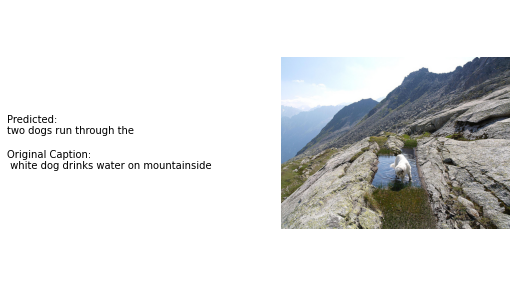

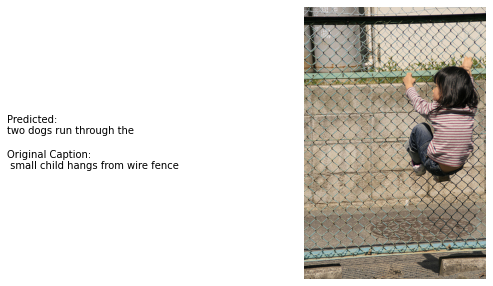

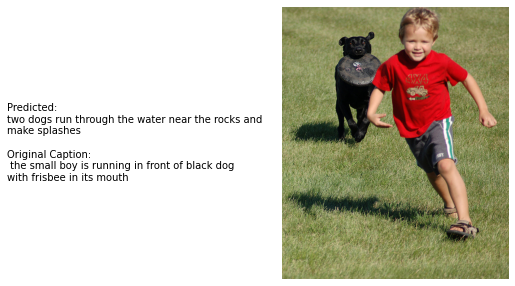

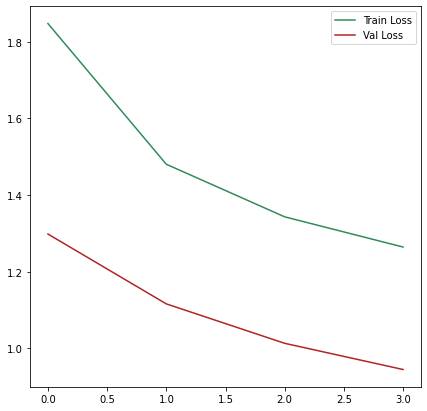

In [194]:
def load_info_and_visualize(model_name):
  with open(os.path.join(SAVE_LOCATION, f"{model_name}.json")) as jfile:
      info = json.load(jfile)
  folder = os.path.join(SAVE_LOCATION, f"{model_name}_result")
  if not os.path.isdir(folder):
    os.mkdir(folder)

  visualize_model(model, folder, info)

load_info_and_visualize("part_a")

## Train Part B

In this part we unfreeze the resnet layers

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=False,
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5,weight_decay=10e-3)

torch.cuda.empty_cache()

In [ ]:
part_b_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_b", max_epochs=MAX_EPOCHS)

In [ ]:
load_info_and_visualize("part_b")

### Part C

In this part we use a bidirectional LSTM but with Freezing

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=True,
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-4,weight_decay=10e-3)

torch.cuda.empty_cache()

In [ ]:
part_c_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_c", max_epochs=MAX_EPOCHS)

In [ ]:
load_info_and_visualize("part_c")

### Part D

In this part we use a bidirectional LSTM but without freezing resnet layers

In [ ]:
model = FlickrNet(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_size=LSTM_HIDDEN_SIZE,
    padding_idx=vocab[PAD_TOKEN],
    start_token_index=vocab[START_TOKEN],
    end_token_index=vocab[END_TOKEN],           
    unk_token_index=vocab[UNK_TOKEN],
    bidirectional=False,
    dropout=0,
    freeze=False,
    ).cuda()

loss_function = nn.CrossEntropyLoss(reduction='mean').cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5,weight_decay=10e-3)

torch.cuda.empty_cache()

In [ ]:
part_d_info = train(model, optimizer, loss_function, train_loader, test_loader, "part_d", max_epochs=MAX_EPOCHS)

In [ ]:
load_info_and_visualize("part_d")